<a href="https://colab.research.google.com/github/riyachiraniya/Sentiment-Analysis-Of-Twitter-and-Reddit/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing all the necessary library required
import pandas as pd
import numpy as np
import seaborn as sns
#data visualization library based on Matplotlib that provides a high-level interface for drawing attractive and informative statistical graphics
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense,LSTM,GlobalMaxPooling1D,Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,confusion_matrix
import re,string,nltk
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer,WordNetLemmatizer
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df2=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/twitter_dataset/Twitter_Data.csv')
df1=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/twitter_dataset/Reddit_Data.csv')

In [ ]:
df1.head()

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [ ]:
#renaming the columns
df2.columns=['messages','labels']
df1.columns=['messages','labels']

In [ ]:
df1.head()

,messages,labels
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [ ]:
df2.head()

,messages,labels
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [ ]:
df = pd.concat([df1, df2], ignore_index = True)

In [ ]:
df['messages'].iloc[0]

' family mormon have never tried explain them they still stare puzzled from time time like some kind strange creature nonetheless they have come admire for the patience calmness equanimity acceptance and compassion have developed all the things buddhism teaches '

In [ ]:
df['messages'].iloc[100]

' want move gujarat and live there for few months any city that you can recommend '

In [ ]:
df.head()

,messages,labels
0,family mormon have never tried explain them t...,1.0
1,buddhism has very much lot compatible with chr...,1.0
2,seriously don say thing first all they won get...,-1.0
3,what you have learned yours and only yours wha...,0.0
4,for your own benefit you may want read living ...,1.0


In [ ]:
df['length']=df['messages'].str.len()

<Axes: ylabel='Frequency'>

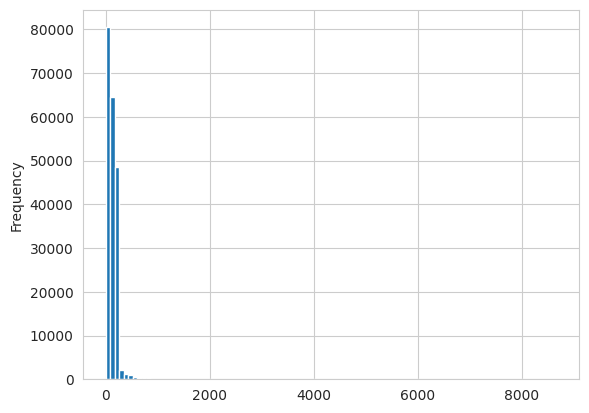

In [ ]:
#plotting the frequency of each unique length
sns.set_style('whitegrid')
df['length'].plot(kind='hist',bins=100,)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200229 entries, 0 to 200228
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   messages  200125 non-null  object 
 1   labels    200222 non-null  float64
 2   length    200125 non-null  float64
dtypes: float64(2), object(1)
memory usage: 4.6+ MB


In [ ]:
df.describe()

,labels,length
count,200222.000000,200125.000000
mean,0.221219,134.796737
std,0.780813,167.639234
min,-1.000000,1.000000
25%,0.000000,61.000000
50%,0.000000,109.000000
75%,1.000000,183.000000
max,1.000000,8665.000000


In [ ]:
#from the describe function we got to know that the longest message is of length 8665
df[df['length']==8665]['messages'].iloc[0]

'brilliant point point breakdown one other argument making the rounds false argument okay maybe the strikes took place but should have been kept secret and deniable there good reason for dgmo make statements about covert actions except for bjp score political points there are massive number reasons make strike like this public exposes pakistan bluster just tough talk for all their talk being high alert for indian troop movement along the loc after the uri attack they didn even see coming massively boosts morale within the armed forces morale which has been getting steadily lower our bases kept getting hit while they were not allowed take charge the offensive the troops are also being vilified the media national and international while trying control spiral violence srinagar fueled pakistan propaganda machine makes the best use pakistan blunder overreaching and outmaneuvers them pakistan has its hands tied now after making bold statements about defending against indian adventurism aggre

In [ ]:
df['labels']=df['labels'].map({-1:'negative',0:'neutral',1:'positive'})

In [ ]:
#checking the null values in the dataset
df.isnull().sum()

messages    104
labels        7
length      104
dtype: int64

In [ ]:
#removing the null value witg dropna()
df=df.dropna()

In [ ]:
len(df['messages'])

200118

In [ ]:
#cleaning the data from unnecessary data

#replacing url with string URL
def replace_url(text):
    return re.sub('https?:\/\/\S*|www\.\S+','URL',text)

#removing html
def remove_html(text):
    return re.sub('<.*?>','',text)

#replacing mentions with string user
def replace_mentions(text):
    return re.sub('@\S*','user',text,flags=re.IGNORECASE)

#replacing numbers with string number
def replace_num(text):
    return re.sub('^[+-]*?\d{1,3}[- ]*?\d{1,10}|\d{10}','NUMBER',text)

#replacing <3 with sring heart
def replace_heart(text):
    return re.sub('<3','HEART', text)

#removing all english stopwords
def remove_stopwords(text):
    text = ' '.join([word for word in text.split() if word not in stopwords.words("english")])
    return text

#removing punctuations
def remove_punctuations(text):
    text=''.join([word for word in text if word not in string.punctuation])
    return text

#reducing words to thier root form
def lemmatization(text):
    lm= WordNetLemmatizer()
    #pos = parts of speech v - verb n - noun
    text = ' '.join([lm.lemmatize(word, pos='v') for word in text.split()])
    return text

In [ ]:
def clean_text(text):
    text=str(text).lower()
    text = replace_url(text)
    text = remove_html(text)
    text = replace_mentions(text)
    text = replace_num(text)
    text = replace_heart(text)
    text = remove_stopwords(text)
    text=remove_punctuations(text)
    text=lemmatization(text)
    return text

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
from nltk.corpus import wordnet
df['messages1']=df['messages'].apply(clean_text)

In [ ]:
df['messages1']

0         family mormon never try explain still stare pu...
1         buddhism much lot compatible christianity espe...
2         seriously say thing first get complex explain ...
3         learn want teach different focus goal wrap pap...
4         benefit may want read live buddha live christ ...
                                ...                        
200224    456 crores pay neerav modi recover congress le...
200225    dear rss terrorist payal gawar modi kill 1000 ...
200226                        cover interaction forum leave
200227    big project come india modi dream project happ...
200228    ever listen like gurukul discipline maintain e...
Name: messages1, Length: 200118, dtype: object

In [ ]:
#splitting the data for training and testing
X=df['messages1'].values
# converting the categorical labels into one-hot encoded vectors
y = pd.get_dummies(df['labels']).values
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.33)

In [ ]:
X_train.shape

(134079,)

In [ ]:
#converting the messages into tokens and then converting them into matrix of integers
Max_vocab_size=50000
tokenizer=Tokenizer(num_words=Max_vocab_size)
tokenizer.fit_on_texts(X_train)
sequence_Xtrain=tokenizer.texts_to_sequences(X_train)
sequence_Xtest=tokenizer.texts_to_sequences(X_test)

In [ ]:
V=len(tokenizer.word_index)

In [ ]:
tokenizer.word_index

{'modi': 1,
 'india': 2,
 'say': 3,
 'people': 4,
 'bjp': 5,
 'like': 6,
 'get': 7,
 'congress': 8,
 'give': 9,
 'make': 10,
 'vote': 11,
 'one': 12,
 'time': 13,
 'narendra': 14,
 'take': 15,
 'know': 16,
 'govt': 17,
 'come': 18,
 'want': 19,
 'think': 20,
 'country': 21,
 'even': 22,
 'see': 23,
 'dont': 24,
 'indian': 25,
 'also': 26,
 'years': 27,
 'party': 28,
 'would': 29,
 'good': 30,
 'election': 31,
 'work': 32,
 'go': 33,
 'government': 34,
 'modis': 35,
 'rahul': 36,
 'need': 37,
 'nation': 38,
 'power': 39,
 'support': 40,
 'minister': 41,
 'ask': 42,
 'money': 43,
 'pakistan': 44,
 'use': 45,
 'gandhi': 46,
 'hai': 47,
 'credit': 48,
 'right': 49,
 'win': 50,
 'back': 51,
 'become': 52,
 'do': 53,
 'every': 54,
 'show': 55,
 'space': 56,
 'much': 57,
 'never': 58,
 'many': 59,
 'job': 60,
 'call': 61,
 'new': 62,
 'media': 63,
 'elections': 64,
 'prime': 65,
 'live': 66,
 'well': 67,
 'sir': 68,
 'promise': 69,
 'question': 70,
 'state': 71,
 'still': 72,
 'try': 73,
 'op

In [ ]:
#padding the integer matrix with zero so that all the data have the same length
data_train=pad_sequences(sequence_Xtrain)

In [ ]:
#extracting the number of columns
T=data_train.shape[1]
print(T)

858


In [ ]:
data_test=pad_sequences(sequence_Xtest,maxlen=T)

In [ ]:
data_train.shape

(134079, 858)

In [ ]:
data_test.shape

(66039, 858)

In [ ]:
D=20 #No of features
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=10)
i=Input(shape=(T,))
x=Embedding(V+1,D)(i)
x=LSTM(128,dropout=(0.2))(x)
x=Dense(3,activation='softmax')(x)
model=Model(i,x)
model.compile(optimizer='RMSProp',loss='categorical_crossentropy',metrics=['accuracy'])
history=model.fit(data_train,y_train,batch_size=128,validation_data=(data_test,y_test),epochs=25,callbacks=[early_stop])

Epoch 1/25
1048/1048 [==============================] - 109s 101ms/step - loss: 0.6544 - accuracy: 0.7267 - val_loss: 0.4458 - val_accuracy: 0.8382
Epoch 2/25
1048/1048 [==============================] - 71s 68ms/step - loss: 0.3975 - accuracy: 0.8605 - val_loss: 0.3995 - val_accuracy: 0.8693
Epoch 3/25
1048/1048 [==============================] - 67s 64ms/step - loss: 0.3543 - accuracy: 0.8801 - val_loss: 0.3699 - val_accuracy: 0.8777
Epoch 4/25
1048/1048 [==============================] - 67s 64ms/step - loss: 0.3336 - accuracy: 0.8888 - val_loss: 0.3594 - val_accuracy: 0.8804
Epoch 5/25
1048/1048 [==============================] - 65s 62ms/step - loss: 0.3174 - accuracy: 0.8957 - val_loss: 0.3613 - val_accuracy: 0.8826
Epoch 6/25
1048/1048 [==============================] - 64s 61ms/step - loss: 0.3037 - accuracy: 0.9009 - val_loss: 0.3547 - val_accuracy: 0.8815
Epoch 7/25
1048/1048 [==============================] - 63s 60ms/step - loss: 0.3099 - accuracy: 0.8969 - val_loss: 0.3588

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 858)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 858, 20)           1993740   
                                                                 
 lstm_2 (LSTM)               (None, 128)               76288     
                                                                 
 dense_2 (Dense)             (None, 3)                 387       
                                                                 
Total params: 2070415 (7.90 MB)
Trainable params: 2070415 (7.90 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#evaluating the model performance
model.evaluate(data_test,y_test)

2064/2064 [==============================] - 32s 15ms/step - loss: 0.3864 - accuracy: 0.8776


[0.38642066717147827, 0.8775723576545715]

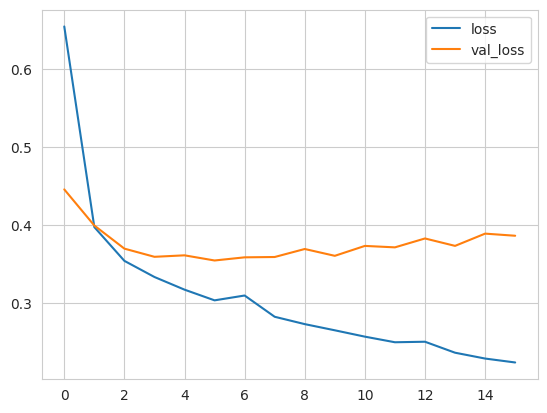

In [ ]:

plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()

In [ ]:
predictions=model.predict(data_test).argmax(axis=1)

2064/2064 [==============================] - 33s 16ms/step


In [ ]:
print(classification_report(y_test.argmax(axis=1),predictions))

              precision    recall  f1-score   support

           0       0.84      0.79      0.81     14457
           1       0.87      0.93      0.90     22476
           2       0.90      0.88      0.89     29106

    accuracy                           0.88     66039
   macro avg       0.87      0.87      0.87     66039
weighted avg       0.88      0.88      0.88     66039

